---
<center>

  # **Tarea 10: Hartee Fock**

**Realizado Por:**

   Samuel Huertas Rojas

---
</center>


 Construyendo base inicial (hidrógeno)...
   ✓ Base inicializada

🔧 Preparando cálculo...
 Construyendo Hamiltoniano DVR...
   Total de elementos: 63001
   ✓ Hamiltoniano construido

INICIANDO CÁLCULO HARTREE-FOCK AUTOCONSISTENTE

────────────────────────────────────────────────────────────
📍 ITERACIÓN 0
────────────────────────────────────────────────────────────
    Diagonalizando...
   🔄 Actualizando Hamiltoniano completo...
    Construyendo Hamiltoniano reducido...
    Calculando energía...

   ⚡ Energía = -2.829723 u.a.

────────────────────────────────────────────────────────────
📍 ITERACIÓN 1
────────────────────────────────────────────────────────────
    Diagonalizando...
   🔄 Actualizando Hamiltoniano completo...
    Construyendo Hamiltoniano reducido...
    Calculando energía...

   ⚡ Energía = -2.837570 u.a.
   Δ Energía = 7.85e-03

────────────────────────────────────────────────────────────
📍 ITERACIÓN 2
────────────────────────────────────────────────────────────
    Di

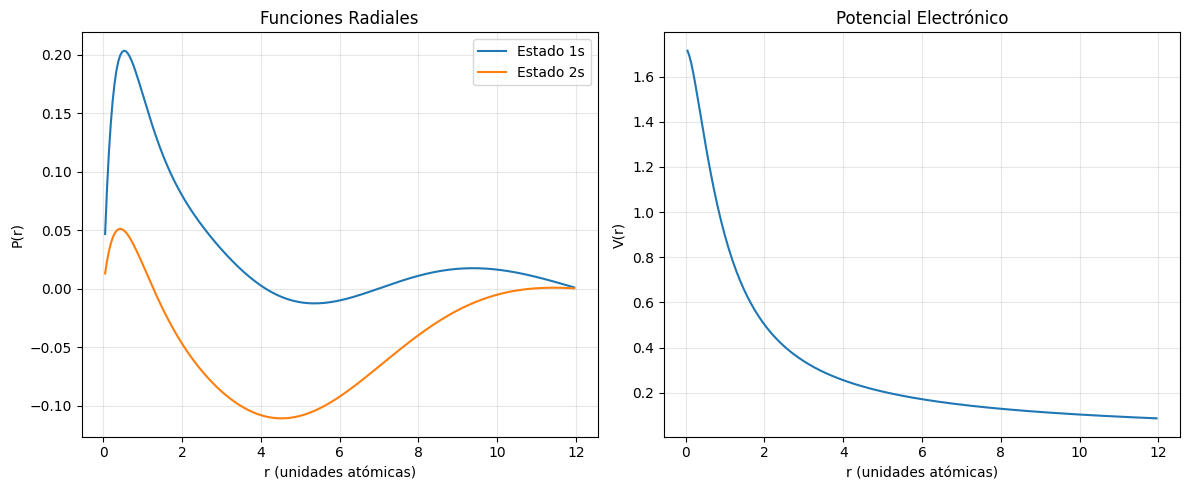

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.hydrogen import R_nl

# ==================== CONSTANTES FÍSICAS ====================
ALPHA = 1 / 137.036  # Constante de estructura fina
VELOCIDAD_LUZ = 1 / ALPHA
MASA_REDUCIDA = 1
CARGA_ELECTRON = 1
HBAR = 1
Z_HELIO = 2  # Número atómico del helio

# Factores de conversión de unidades atómicas
FACTORES_CONVERSION = {
    "joules": 4.3598e-18,
    "cm^-1": 219474.6313,
    "eV": 27.2114
}


# ==================== CLASE DVR ====================
class RepresentacionDVR:
    """
    Discrete Variable Representation (DVR)
    Representa funciones en una base de puntos discretos
    """
    
    def __init__(self, r_inicial, r_final, num_puntos):
        """
        Args:
            r_inicial: Punto radial inicial
            r_final: Punto radial final
            num_puntos: Número de puntos DVR
        """
        self.num_puntos = num_puntos
        self.r_inicial = r_inicial
        self.r_final = r_final
        self.longitud = np.abs(r_final - r_inicial)
        
        # Pre-calcular puntos DVR
        self.puntos_radiales = [
            self.calcular_punto_radial(n) 
            for n in range(1, self.num_puntos + 1)
        ]
    
    def calcular_punto_radial(self, n):
        """Calcula la posición del n-ésimo punto DVR"""
        return n * self.longitud / (self.num_puntos + 1) + self.r_inicial
    
    def elemento_matriz_cinetica(self, i, j):
        """
        Calcula el elemento de matriz (i,j) del operador de energía cinética
        
        Args:
            i, j: Índices de los puntos DVR
            
        Returns:
            Elemento de matriz del operador -ℏ²/2m ∇²
        """
        factor = -2 * np.pi**2 / ((self.num_puntos + 1) * self.longitud**2)
        
        suma = sum(
            k**2 * np.sin(i * k * np.pi / (self.num_puntos + 1)) 
                 * np.sin(j * k * np.pi / (self.num_puntos + 1))
            for k in range(1, self.num_puntos + 1)
        )
        
        return factor * suma
    
    def construir_hamiltoniano(self, potencial, masa, *args_potencial):
        """
        Construye la matriz hamiltoniana completa
        H = T + V (energía cinética + potencial)
        """
        print(" Construyendo Hamiltoniano DVR...")
        print(f"   Total de elementos: {self.num_puntos**2}")
        
        hamiltoniano = np.zeros((self.num_puntos, self.num_puntos))
        
        for i in range(1, self.num_puntos + 1):
            for j in range(i, self.num_puntos + 1):
                # Progreso
                if (i * self.num_puntos + j) % 1000 == 0:
                    print(f"   Procesado: {i * self.num_puntos + j}", end="\r")
                
                # Energía cinética
                elemento = -(HBAR**2) / (2 * masa) * self.elemento_matriz_cinetica(i, j)
                
                # Energía potencial (solo diagonal)
                if i == j:
                    r_punto = self.calcular_punto_radial(i)
                    elemento += potencial(r_punto, *args_potencial)
                
                # Matriz simétrica
                hamiltoniano[i-1, j-1] = hamiltoniano[j-1, i-1] = elemento
        
        print("   ✓ Hamiltoniano construido")
        return hamiltoniano


# ==================== CLASE POTENCIAL ====================
class PotencialElectronico:
    """
    Potencial de interacción electrón-electrón en el método Hartree-Fock
    V(r) = ∫ ρ(r') / |r-r'| dr'
    """
    
    def __init__(self, dvr):
        self.dvr = dvr
        self.densidad_electronica = None  # ρ(r) = |ψ(r)|²
    
    def __call__(self, r):
        """
        Evalúa el potencial en el punto r
        Usa aproximación: min(1/r, 1/r') para evitar divergencias
        """
        if self.densidad_electronica is None:
            return 0.0
        
        potencial = 0.0
        for i in range(self.dvr.num_puntos):
            r_prima = self.dvr.calcular_punto_radial(i + 1)
            # Aproximación del término 1/|r-r'|
            potencial += self.densidad_electronica[i]**2 * min(1/r, 1/r_prima)
        
        return potencial
    
    def actualizar_densidad(self, funcion_onda):
        """Actualiza la densidad electrónica ρ(r) = |ψ(r)|²"""
        self.densidad_electronica = np.copy(funcion_onda)


# ==================== CLASE PRINCIPAL ====================
class AtomoHelioHartreeFock:
    """
    Implementación del método Hartree-Fock autoconsistente
    para el átomo de helio
    """
    
    def __init__(self, num_estados=10, r_inicial=0, r_final=12, num_puntos=251):
        """
        Args:
            num_estados: Número de estados base para expansión
            r_inicial: Radio inicial de la caja
            r_final: Radio final de la caja
            num_puntos: Número de puntos DVR
        """
        self.num_estados = num_estados
        self.dvr = RepresentacionDVR(r_inicial, r_final, num_puntos)
        self.potencial = PotencialElectronico(self.dvr)
        
        # Inicializar con funciones del hidrógeno
        self._inicializar_funciones_base()
        
        # Pre-calcular hamiltoniano cinético
        print("\n🔧 Preparando cálculo...")
        self.hamiltoniano_cinetico = self.dvr.construir_hamiltoniano(
            lambda x: 0, MASA_REDUCIDA
        )
    
    def funcion_radial_hidrogenoide(self, n, r):
        """
        Función radial del hidrógeno: P(r) = r * R_nl(r)
        Para estados s (l=0)
        """
        return r * R_nl(n, 0, r, Z_HELIO).n()
    
    def _inicializar_funciones_base(self):
        """Inicializa con funciones radiales del hidrógeno"""
        print("\n Construyendo base inicial (hidrógeno)...")
        
        funciones = []
        for n in range(self.num_estados):
            funcion = [
                float(self.funcion_radial_hidrogenoide(n + 1, r))
                for r in self.dvr.puntos_radiales
            ]
            
            # Normalizar
            norma = np.linalg.norm(funcion)
            funcion_normalizada = np.array(funcion) / norma
            funciones.append(funcion_normalizada)
        
        self.funciones_base = funciones
        
        # Inicializar potencial con estado fundamental del hidrógeno
        self.potencial.actualizar_densidad(self.funciones_base[0])
        print("   ✓ Base inicializada")
    
    def actualizar_hamiltoniano_completo(self):
        """Actualiza el hamiltoniano con el potencial actual"""
        print("   🔄 Actualizando Hamiltoniano completo...")
        
        self.hamiltoniano = np.copy(self.hamiltoniano_cinetico)
        
        # Añadir potencial nuclear y electrónico
        for i in range(self.dvr.num_puntos):
            r = self.dvr.calcular_punto_radial(i + 1)
            
            # V_nuclear + V_electronico
            potencial_total = -Z_HELIO / r + self.potencial(r)
            self.hamiltoniano[i, i] += potencial_total
    
    def construir_hamiltoniano_reducido(self):
        """
        Proyecta el hamiltoniano en la base de funciones
        H_reducido[i,j] = ⟨φᵢ|H|φⱼ⟩
        """
        print("    Construyendo Hamiltoniano reducido...")
        
        H_red = np.zeros((self.num_estados, self.num_estados))
        
        for i, j in itertools.product(range(self.num_estados), repeat=2):
            if j >= i:  # Aprovechar simetría
                elemento = sum(
                    self.funciones_base[i][k] * self.funciones_base[j][l] 
                    * self.hamiltoniano[k, l]
                    for k, l in itertools.product(  # noqa: E741
                        range(self.dvr.num_puntos), repeat=2
                    )
                )
                H_red[i, j] = H_red[j, i] = elemento
        
        self.hamiltoniano_reducido = H_red
    
    def obtener_estado_fundamental(self):
        """
        Resuelve el problema de autovalores y extrae el estado fundamental
        """
        print("    Diagonalizando...")
        
        # Actualizar hamiltoniano
        self.actualizar_hamiltoniano_completo()
        self.construir_hamiltoniano_reducido()
        
        # Diagonalizar
        autovalores, autovectores = np.linalg.eigh(
            self.hamiltoniano_reducido, UPLO='L'
        )
        
        # Encontrar estado de mínima energía
        idx_minimo = np.argmin(autovalores)
        
        # Reconstruir función de onda en base DVR
        funcion_1s = sum(
            autovectores[k, idx_minimo] * self.funciones_base[k]
            for k in range(self.num_estados)
        )
        
        # Actualizar base con nuevos autovectores
        self.funciones_base = [
            sum(autovectores[k, i] * self.funciones_base[k] 
                for k in range(self.num_estados))
            for i in range(self.num_estados)
        ]
        
        return funcion_1s
    
    def calcular_energia_total(self, funcion_1s):
        """
        Calcula la energía total del sistema
        E = 2*E₁ + E₂
        donde E₁ es energía de un electrón y E₂ la interacción
        """
        print("    Calculando energía...")
        
        # E₁: Energía cinética + potencial nuclear (un electrón)
        E1 = 0.0
        for i, j in itertools.product(range(self.dvr.num_puntos), repeat=2):
            E1 += (funcion_1s[i] * funcion_1s[j] 
                   * (-(HBAR**2) / (2 * MASA_REDUCIDA)) 
                   * self.dvr.elemento_matriz_cinetica(i+1, j+1))
        
        for i in range(self.dvr.num_puntos):
            r = self.dvr.calcular_punto_radial(i + 1)
            E1 -= funcion_1s[i]**2 * Z_HELIO / r
        
        # E₂: Energía de interacción electrón-electrón
        E2 = 0.0
        for i in range(self.dvr.num_puntos):
            r = self.dvr.calcular_punto_radial(i + 1)
            E2 += funcion_1s[i]**2 * self.potencial(r)
        
        return 2 * E1 + E2
    
    def resolver_autoconsistente(self, max_iteraciones=5, tolerancia=1e-5):
        """
        Ciclo autoconsistente del método Hartree-Fock
        
        Args:
            max_iteraciones: Número máximo de iteraciones
            tolerancia: Criterio de convergencia
            
        Returns:
            Energía del estado fundamental
        """
        print("\n" + "="*60)
        print("INICIANDO CÁLCULO HARTREE-FOCK AUTOCONSISTENTE")
        print("="*60)
        
        energia_anterior = 0.0
        
        for iteracion in range(max_iteraciones):
            print(f"\n{'─'*60}")
            print(f"📍 ITERACIÓN {iteracion}")
            print(f"{'─'*60}")
            
            # Obtener nueva función de onda del estado fundamental
            funcion_1s = self.obtener_estado_fundamental()
            
            # Actualizar potencial con nueva densidad
            self.potencial.actualizar_densidad(funcion_1s)
            
            # Calcular energía
            energia = self.calcular_energia_total(funcion_1s)
            
            # Mostrar resultados
            print(f"\n   ⚡ Energía = {energia:.6f} u.a.")
            
            if iteracion > 0:
                diferencia = abs(energia - energia_anterior)
                print(f"   Δ Energía = {diferencia:.2e}")
                
                if diferencia < tolerancia:
                    print("\n✅ CONVERGENCIA ALCANZADA")
                    break
            
            energia_anterior = energia
        
        print("\n" + "="*60)
        print(f"RESULTADO FINAL: E = {energia:.6f} u.a.")
        print("   (Experimental: -2.9037 u.a.)")
        print(f"   Error: {abs(energia + 2.9037):.4f} u.a.")
        print("="*60 + "\n")
        
        return energia


# ==================== VISUALIZACIÓN ====================
def graficar_resultados(atomo):
    """Genera gráficas de las funciones y el potencial"""
    x = atomo.dvr.puntos_radiales
    
    # Figura 1: Funciones de onda base
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, atomo.funciones_base[0], label='Estado 1s')
    plt.plot(x, atomo.funciones_base[1], label='Estado 2s')
    plt.xlabel('r (unidades atómicas)')
    plt.ylabel('P(r)')
    plt.title('Funciones Radiales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Figura 2: Potencial efectivo
    plt.subplot(1, 2, 2)
    y_pot = [atomo.potencial(r) for r in x]
    plt.plot(x, y_pot)
    plt.xlabel('r (unidades atómicas)')
    plt.ylabel('V(r)')
    plt.title('Potencial Electrónico')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ==================== EJECUCIÓN PRINCIPAL ====================
# Crear átomo de helio
helio = AtomoHelioHartreeFock(
    num_estados=10,
    r_inicial=0,
    r_final=12,
    num_puntos=251
)

# Resolver método Hartree-Fock
energia_final = helio.resolver_autoconsistente(max_iteraciones=5)

# Visualizar resultados
graficar_resultados(helio)